# Imports

Learning about classification tasks.

I will be using the MNIST dataset. It consists of images of handwritten digits (0-9).

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

In [3]:
# Plot style

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

# MNIST dataset

## Setup

In [4]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', as_frame=False)

In [5]:
IMAGE_PATH = Path("../images/classification")
IMAGE_PATH.mkdir(parents=True, exist_ok=True)

In [6]:
X, y = mnist.data, mnist.target

## Exploration and some visualization

In [7]:
def info(X, y, x_name="X", y_name="y"):
	print(f"{x_name} shape: {X.shape}")
	print("-"*20)
	print(X)
	print("-"*20)
	print(f"{y_name} shape: {y.shape}")
	print("-"*20)
	print(y)

In [8]:
info(X, y)

X shape: (70000, 784)
--------------------
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
--------------------
y shape: (70000,)
--------------------
['5' '0' '4' ... '4' '5' '6']


Label: 5


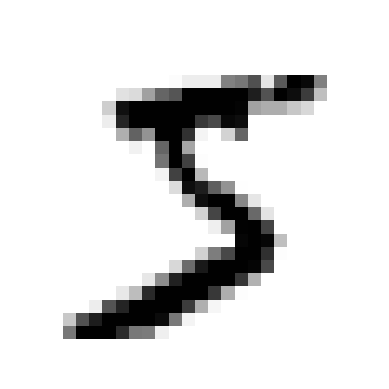

In [9]:
def plot_digit(data):
	image = data.reshape(28, 28)
	plt.imshow(image, cmap="binary")
	plt.axis("off")

some_index = 0
some_digit = X[some_index]
plot_digit(some_digit)
print(f"Label: {y[some_index]}")

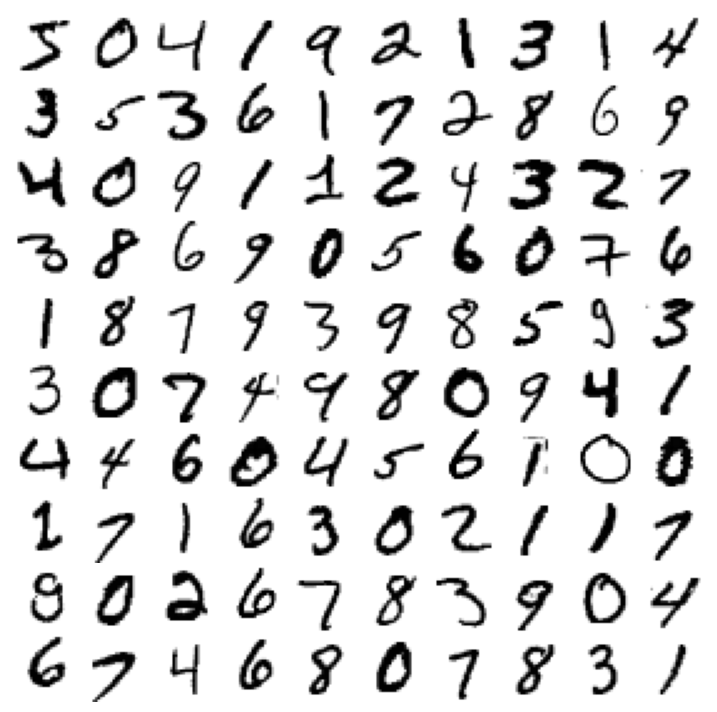

In [10]:
plt.figure(figsize=(9, 9))
for index, image_data in enumerate(X[:100]):
	plt.subplot(10, 10, index+1)
	plot_digit(image_data)
	plt.subplots_adjust(wspace=0, hspace=0)

## Train test split

In [11]:
# The dataset is already split into training and test sets
# The first 60,000 images are the training set and the last 10,000 are the test set

X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

# Binary Classifier

In [12]:
# Firstly, we will train a binary classifier to classify the digit 5
# This will be a "5-detector"

y_train_5 = (y_train == '5')
y_test_5 = (y_test == '5')

# True when the label is 5, False otherwise

In [13]:
# Starting with the Stochastic Gradient Descent (SGD) classifier

from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [14]:
sgd_clf.predict([some_digit])

array([ True])

## Performance

In [15]:
# Using cross-val

from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

1    0.11
7    0.10
3    0.10
2    0.10
9    0.10
0    0.10
6    0.10
8    0.10
4    0.10
5    0.09
Name: proportion, dtype: float64


<Axes: >

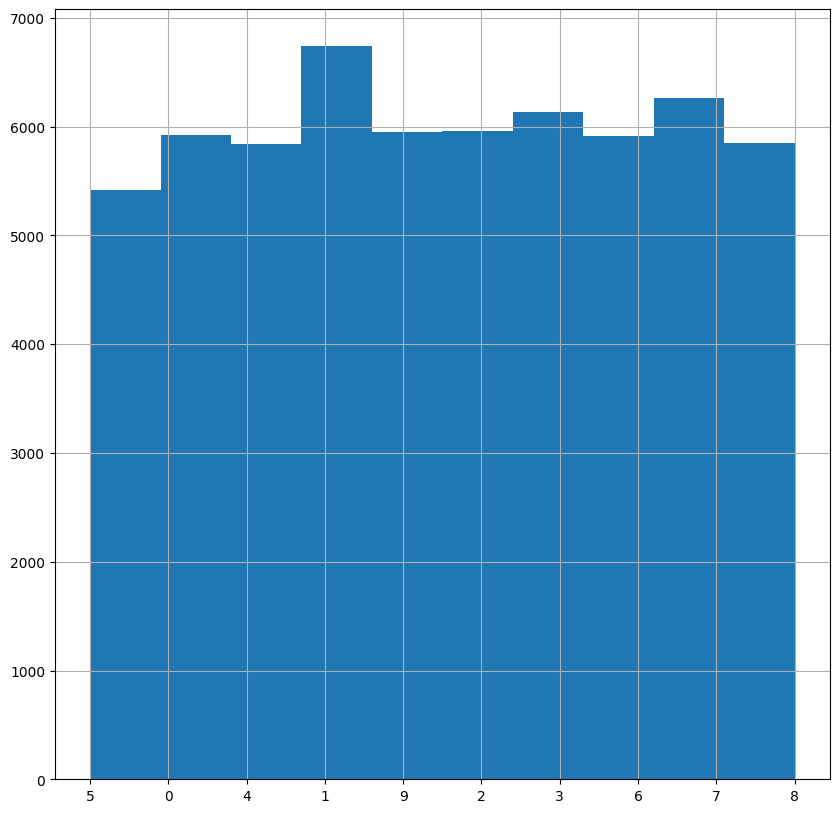

In [29]:
# Apparently great. However, only 10% of the images are 5s
# Quick check

print(pd.Series(y_train).value_counts(normalize=True).round(2))
pd.Series(y_train).hist(bins=10, figsize=(10, 10))

In [31]:
# Comparing to a dummy classifier

from sklearn.dummy import DummyClassifier

# This classifier will always predict that the image is not a 5
dummy_clf = DummyClassifier()
dummy_clf.fit(X_train, y_train_5)
print(any(dummy_clf.predict(X_train)))

False


In [32]:
# Looking at cross-val scores
cross_val_score(dummy_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.90965, 0.90965, 0.90965])

In [34]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone
from sklearn.linear_model import SGDClassifier

def custom_cross_val(X_train, y_train, cv=3, shuffle=True, random_state=42):
	skfolds = StratifiedKFold(n_splits=cv, shuffle=shuffle, random_state=random_state)

	for train_index, test_index in skfolds.split(X_train, y_train):
		clone_clf = clone(SGDClassifier(random_state=random_state))
		X_train_folds = X_train[train_index]
		y_train_folds = y_train[train_index]
		X_test_fold = X_train[test_index]
		y_test_fold = y_train[test_index]

		clone_clf.fit(X_train_folds, y_train_folds)
		y_pred = clone_clf.predict(X_test_fold)
		n_correct = sum(y_pred == y_test_fold)
		print(n_correct / len(y_pred))

## Confusion Matrix

In [35]:
from sklearn.model_selection import cross_val_predict

# cross_val_predict returns the predictions made on each test fold
# instead of the evaluation scores

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [39]:
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(y_train_5, y_train_pred)
conf_matrix

# Rows == actual classes
# Columns == predicted classes

print(conf_matrix)
print(f"True negatives: {conf_matrix[0, 0]}")
print(f"False positives: {conf_matrix[0, 1]}")
print(f"False negatives: {conf_matrix[1, 0]}")
print(f"True positives: {conf_matrix[1, 1]}")

[[53892   687]
 [ 1891  3530]]
True negatives: 53892
False positives: 687
False negatives: 1891
True positives: 3530


In [41]:
y_train_perfect_predictions = y_train_5
conf_matrix_perfect = confusion_matrix(y_train_5, y_train_perfect_predictions)
conf_matrix_perfect

array([[54579,     0],
       [    0,  5421]], dtype=int64)

Precision: 

$$ 
precision = \frac{TP}{Positives} = \frac{TP}{TP + FP} 
$$

Recall:

$$
recall = \frac{TP}{Actual Positives} = \frac{TP}{TP + FN}
$$

## Precision and Recall

In [43]:
# Sklearn has a function to calculate precision and recall

from sklearn.metrics import precision_score, recall_score

print(f"Precision score: {precision_score(y_train_5, y_train_pred).round(2)}")
print(f"Recall score: {recall_score(y_train_5, y_train_pred).round(2)}")

Precision score: 0.84
Recall score: 0.65


- The $F_1$ score is the harmonic mean of precision and recall. 
- It gives more weight to low values.
- A high $F_1$ score is achieved when both precision and recall are high.

$$
F_1 = \frac{2}{\frac{1}{precision} + \frac{1}{recall}} = 2 \times \frac{precision \times recall}{precision + recall} = \frac{TP}{TP + \frac{FN + FP}{2}}

In [44]:
# Again, sklearn has a function to calculate the F1 score

from sklearn.metrics import f1_score

print(f"F1 score: {f1_score(y_train_5, y_train_pred).round(2)}")

F1 score: 0.73


## Precision/Recall Tradeoff

Precision and recall are inversely related. Depending on the task, you may want to prioritize precision or recall. 

Example:
- Cancer detection: prioritize recall. It is preferable to have false positives (detecting cancer when there is none) than false negatives (missing cancer when it is present).

In [48]:
# The classifier has a decision function and uses a threshold (0) to make predictions
# We can access the decision scores and set our own threshold

y_scores = sgd_clf.decision_function([some_digit])
threshold = 0
y_some_digit_pred = (y_scores > threshold)
print(f"Threshold: {threshold}; Score: {y_scores}; Predicion: {y_some_digit_pred}")

# Raising the threshold
threshold = 3000
y_some_digit_pred = (y_scores > threshold)
print(f"Threshold: {threshold}; Score: {y_scores}; Predicion: {y_some_digit_pred}")

Threshold: 0; Score: [2164.22030239]; Predicion: [ True]
Threshold: 3000; Score: [2164.22030239]; Predicion: [False]


In [49]:
# Using cross-val to get the scores of all instances in the training set

y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

In [50]:
# Using precision_recall_curve to plot precision and recall as functions of the threshold

from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

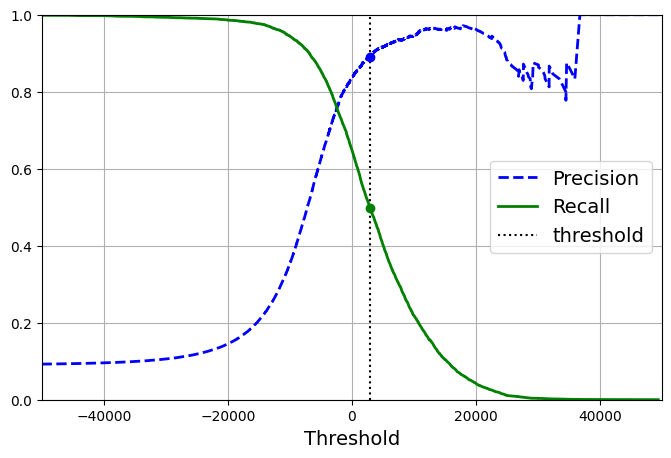

In [51]:
plt.figure(figsize=(8, 5))
plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
plt.vlines(threshold, 0, 1.0, "k", "dotted", label="threshold")

idx = (thresholds >= threshold).argmax()  # first index ≥ threshold
plt.plot(thresholds[idx], precisions[idx], "bo")
plt.plot(thresholds[idx], recalls[idx], "go")
plt.axis([-50000, 50000, 0, 1])
plt.grid()
plt.xlabel("Threshold")
plt.legend(loc="center right")

plt.show()

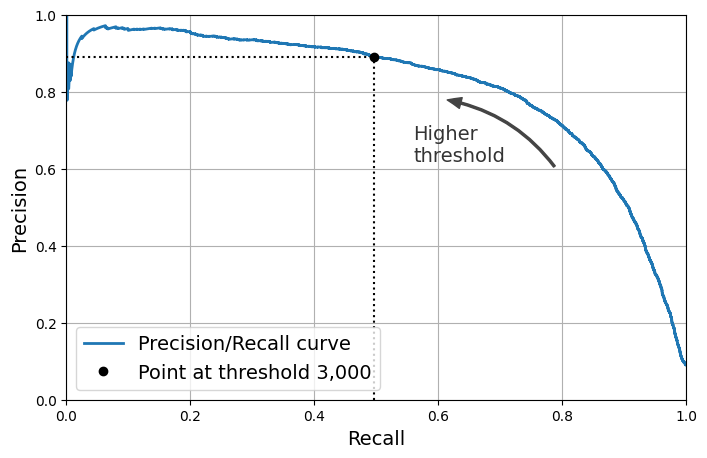

In [52]:
import matplotlib.patches as patches  # extra code – for the curved arrow

plt.figure(figsize=(8, 5))  # extra code – not needed, just formatting

plt.plot(recalls, precisions, linewidth=2, label="Precision/Recall curve")

# extra code – just beautifies
plt.plot([recalls[idx], recalls[idx]], [0., precisions[idx]], "k:")
plt.plot([0.0, recalls[idx]], [precisions[idx], precisions[idx]], "k:")
plt.plot([recalls[idx]], [precisions[idx]], "ko",
         label="Point at threshold 3,000")
plt.gca().add_patch(patches.FancyArrowPatch(
    (0.79, 0.60), (0.61, 0.78),
    connectionstyle="arc3,rad=.2",
    arrowstyle="Simple, tail_width=1.5, head_width=8, head_length=10",
    color="#444444"))
plt.text(0.56, 0.62, "Higher\nthreshold", color="#333333")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
plt.grid()
plt.legend(loc="lower left")

plt.show()

In [54]:
# If I want to ensure a precision p, I can look for the lowest threshold that gives me that precision

p = 0.90
index_p_precision = np.argmax(precisions >= p)
threshold_p_precision = thresholds[index_p_precision]
threshold_p_precision

3370.0194991439557

In [59]:
# The predictions for that threshold
# Precision and recall 

y_train_pred_p = (y_scores >= threshold_p_precision)

print(f"Precision: {precision_score(y_train_5, y_train_pred_p)}")
print(f"Recall: {recall_score(y_train_5, y_train_pred_p)}")

Precision: 0.9000345901072293
Recall: 0.4799852425751706


## ROC Curve

In [60]:
from sklearn.metrics import roc_curve

# False positive rate (FPR) and true positive rate (TPR)
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

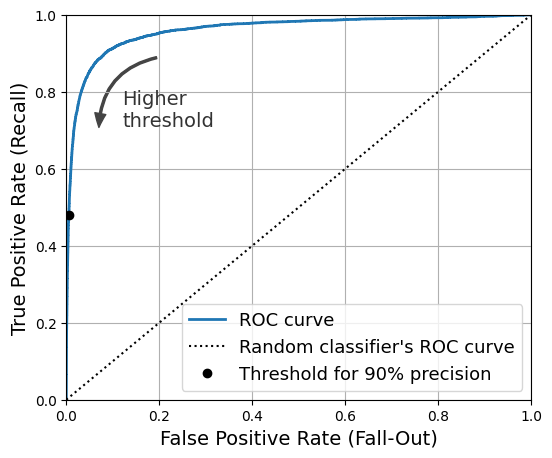

In [61]:
idx_for_threshold_at_90 = (thresholds <= threshold_p_precision).argmax()
tpr_90, fpr_90 = tpr[idx_for_threshold_at_90], fpr[idx_for_threshold_at_90]

plt.figure(figsize=(6, 5))  # extra code – not needed, just formatting
plt.plot(fpr, tpr, linewidth=2, label="ROC curve")
plt.plot([0, 1], [0, 1], 'k:', label="Random classifier's ROC curve")
plt.plot([fpr_90], [tpr_90], "ko", label="Threshold for 90% precision")

# extra code – just beautifies and saves Figure 3–7
plt.gca().add_patch(patches.FancyArrowPatch(
    (0.20, 0.89), (0.07, 0.70),
    connectionstyle="arc3,rad=.4",
    arrowstyle="Simple, tail_width=1.5, head_width=8, head_length=10",
    color="#444444"))
plt.text(0.12, 0.71, "Higher\nthreshold", color="#333333")
plt.xlabel('False Positive Rate (Fall-Out)')
plt.ylabel('True Positive Rate (Recall)')
plt.grid()
plt.axis([0, 1, 0, 1])
plt.legend(loc="lower right", fontsize=13)

plt.show()

In [62]:
# A way to compare classifiers is to calculate the area under the curve (AUC)
# A perfect classifier will have AUC = 1
# A random classifier will have AUC = 0.5

from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9604938554008616

When deciding between the ROC curve and the precision/recall (PR) curve, there are a few factors to consider. 

- If the positive class is rare or if you prioritize minimizing false positives over false negatives, then the PR curve is preferred. 
- On the other hand, if the positive class is not rare and you want to evaluate the overall performance of the classifier, then the ROC curve can be used.


In the case of the previous ROC curve and ROC AUC score, it may appear that the classifier is performing well. However, this is mainly due to the class imbalance, where there are fewer positive instances (5s) compared to the negative instances (non-5s). By examining the PR curve, it becomes evident that there is still room for improvement as the curve could be closer to the top-right corner.

# Random Forest Classifier

In [64]:
# Using a Random Forest Classifier

from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
# RandomForestClassifier does not have a decision_function method
# Instead, it has a predict_proba method
# Using cross-val to get the probabilities of the positive class

y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")

In [66]:
y_probas_forest[:2]

array([[0.11, 0.89],
       [0.99, 0.01]])

In [96]:
# Let's check those probabilities
# The first column is the probability of the negative class
# The second column is the probability of the positive class
# Each row sums to 1 (either positive or negative)

index_50_to_60 = (y_probas_forest[:, 1] > 0.5) & (y_probas_forest[:, 1] < 0.6)
# Indexes where the probability of the positive class is between 0.5 and 0.6
print(f"True probabilities: {y_train_5[index_50_to_60].sum()/index_50_to_60.sum():.2%}")

True probabilities: 93.96%


In [99]:
# PR curve
# Using the positive class probabilities as scores

y_scores_forest = y_probas_forest[:, 1]
precisions_forest, recalls_forest, thresholds_forest = precision_recall_curve(y_train_5, y_scores_forest)

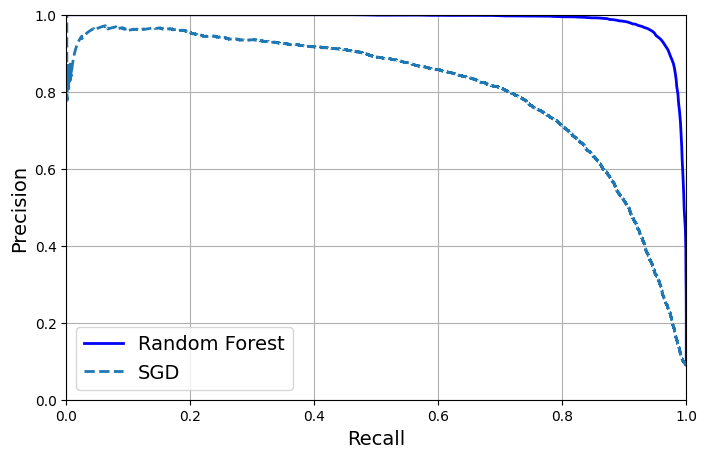

In [101]:
# Plotting the PR curve of SGD and Forest classifiers

plt.figure(figsize=(8, 5)) 

plt.plot(recalls_forest, precisions_forest, "b-", linewidth=2, label="Random Forest")
plt.plot(recalls, precisions, "--", linewidth=2, label="SGD")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
plt.grid()
plt.legend(loc="lower left")

plt.show()

In [107]:
# Precision, Recall, F1 and AUC scores for the Random Forest Classifier

y_pred_forest = (y_scores_forest >= 0.5) # Using 0.5 as the threshold

print(f"Precision: \t {precision_score(y_train_5, y_pred_forest):.5f}")
print(f"Recall: \t {recall_score(y_train_5, y_pred_forest):.5f}")
print(f"F1 score: \t {f1_score(y_train_5, y_pred_forest):.5f}")
print(f"AUC: \t\t {roc_auc_score(y_train_5, y_scores_forest):.5f}")

Precision: 	 0.98975
Recall: 	 0.87253
F1 score: 	 0.92745
AUC: 		 0.99834


# Multiclass Classification

Some Classifiers support multiclass classification nativelly. (Random Forest, GaussianNB, etc)

However, it is possible to use *Binary Classifiers* to perform multiclass classification.
There are two strategies to do this:
- **One-versus-all (OvA)**: Train a binary classifier for each class (0-detector, 1-detector, ...). When classifying a new instance, select the class with the highest score. [N classes, N classifiers]
- **One-versus-one (OvO)**: Train a binary classifier for each pair of classes (0 vs 1, 0 vs 2, ...). When classifying a new instance, select the class that wins the most duels. [N classes, N*(N-1)/2 classifiers]

Sklearn automatically detects when you try to use a binary classifier for a multiclass classification task and it automatically runs OvA or OvO depending on the algorithm.

In [108]:
# Using a Support Vector Machine (SVM) classifier
# It will automatically use the One-vs-One strategy
# This algorithm scales poorly with the size of the training set, so we will use a subset (the first 2000 instances)

from sklearn.svm import SVC

svm_clf = SVC(random_state=42)
svm_clf.fit(X_train[:2000], y_train[:2000])

SVC(random_state=42)

SVM Prediction: ['5']


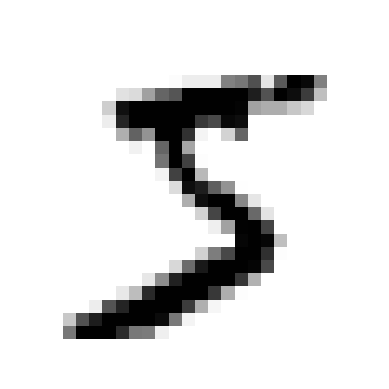

In [112]:
plot_digit(some_digit)
print(f"SVM Prediction: {svm_clf.predict([some_digit])}")

In [114]:
some_digit_scores = svm_clf.decision_function([some_digit])
print(f"SVM Scores: {some_digit_scores.round(2)}")

SVM Scores: [[ 3.79  0.73  6.06  8.3  -0.29  9.3   1.75  2.77  7.21  4.82]]


In [116]:
# Classes are stored in .classes_ attribute
# The index of the class is the same in this case. THIS IS OBVIOUSLY NOT ALWAYS THE CASE

print(f"Classes: {svm_clf.classes_}")

Classes: ['0' '1' '2' '3' '4' '5' '6' '7' '8' '9']


In [117]:
# We can use the OneVsRestClassifier or OneVsOneClassifier classes to force the strategy
# Simply create an insance and pass the classifier to the constructor

from sklearn.multiclass import OneVsRestClassifier

ovr_clf = OneVsRestClassifier(SVC(random_state=42))
ovr_clf.fit(X_train[:2000], y_train[:2000])

OneVsRestClassifier(estimator=SVC(random_state=42))

In [119]:
print(f"Prediction: {ovr_clf.predict([some_digit])}")
print(f"Number of estimators: {len(ovr_clf.estimators_)}")

Prediction: ['5']
Number of estimators: 10


In [120]:
# Using SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train)

SGDClassifier(random_state=42)

In [121]:
print(f"Prediction: {sgd_clf.predict([some_digit])}")
print(f"Scores: {sgd_clf.decision_function([some_digit]).round()}")

Prediction: ['3']
Scores: [[-31893. -34420.  -9531.   1824. -22320.  -1386. -26189. -16148.  -4604.
  -12051.]]


In [122]:
# Evaluating the classifier using cross-val
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

In [123]:
# Scaling the inputs and re-evaluating the classifier
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

## Error Analysis

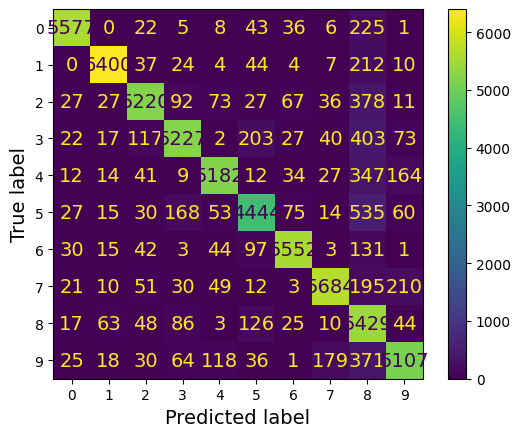

In [124]:
# Using the confusion matrix:
# There will be one row per actual class and one column per predicted class (10x10 matrix)

from sklearn.metrics import ConfusionMatrixDisplay

y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred)
plt.show()

Text(0.5, 1.0, 'Normalized')

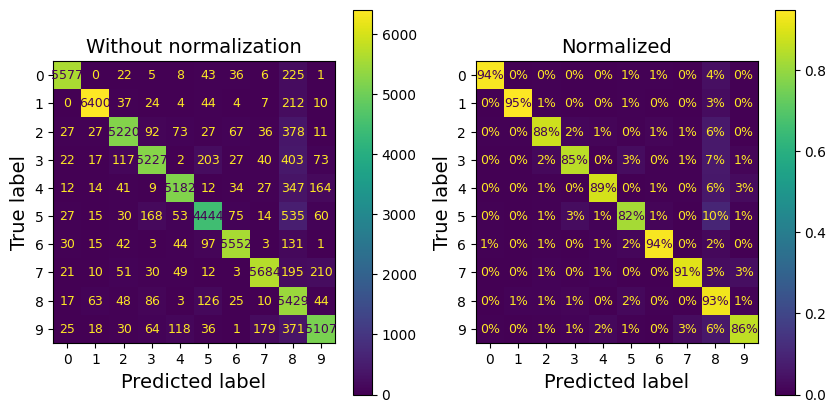

In [131]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
plt.rc('font', size=9)
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, ax=axs[0])
axs[0].set_title("Without normalization")
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, normalize="true", ax=axs[1], values_format=".0%")
axs[1].set_title("Normalized")

Text(0.5, 1.0, 'Error matrix, normalized from columns')

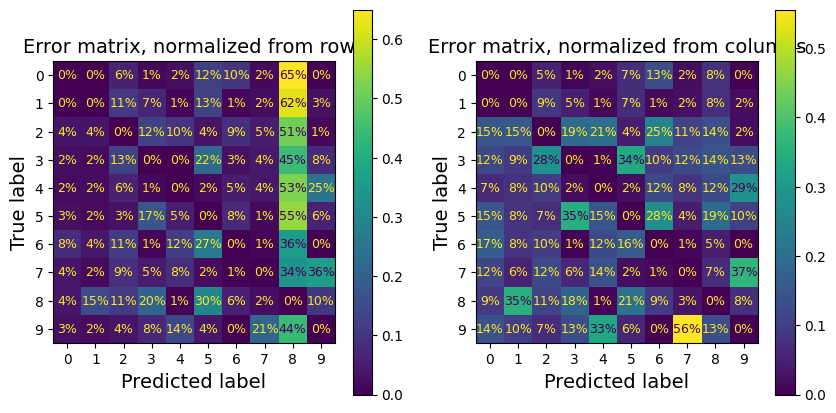

In [134]:
# Error conf mat

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
plt.rc('font', size=9)
sample_weights = (y_train != y_train_pred)
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, sample_weight=sample_weights, normalize='true', ax=axs[0], values_format=".0%")
axs[0].set_title("Error matrix, normalized from rows")
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, sample_weight=sample_weights, normalize='pred', ax=axs[1], values_format=".0%")
axs[1].set_title("Error matrix, normalized from columns")